In [60]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
from wordcloud import WordCloud
import re
import plotly
import seaborn as sns
import stanza
import string 

from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

## Reviews download
https://pypi.org/project/steamreviews/

In [61]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [62]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [63]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [64]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [65]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
28460,Disco Elysium,R,76561198032495173,2,"When someone says an RPG has great writing, th...",0.545454561710357666,True,0,3211,8,1665083787
17881,Portal,P,76561198894891609,57,Glados is actually cute when she is not on a m...,0.767174601554870605,True,61,222,6,1669300696
5819,Sea of Thieves,A,76561199152206793,1,"Game is broken, has billions of bugs that dont...",0.50354611873626709,False,0,19918,1,1686425917
12496,RimWorld,S,76561198002240893,3,Just buy it and stop reading the reviews.,0.525368213653564453,True,518,6063,39,1667039517
31536,Baba Is You,P,76561198010468137,46,This is probably the best puzzle game I've eve...,0.815567433834075928,True,214,2531,14,1566118980


In [66]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [67]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [68]:
df.duplicated(subset='review').sum()

2580

In [69]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
3921,Sea of Thieves,A,76561199134358097,1,good game,0.523809552192687988,True,0,3026,1,2023-03-05 18:02:59
18566,Portal,P,76561199088668886,1,the cake is a lie,0.523809552192687988,True,63,155,24,2023-01-02 13:47:44
21741,Left 4 Dead 2,A,76561198806720149,310,⣿⣿⣿⣿⣿⣿⣿⣿⠟⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣿\n⣿⣿⣿⣿⣿⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢺...,0.892521023750305176,True,0,1057,16,2022-10-24 20:52:24
27807,Portal 2,P,76561198255634871,1,Got a cat here. Friends passing by can touch h...,0.5,True,496,310,79,2023-09-17 22:23:17
9390,Darkest Dungeon,R,76561198257581255,1,really good game,0.523809552192687988,True,472,11143,34,2023-01-11 17:02:00
29220,Disco Elysium,R,76561198092983830,1,yes,0.523809552192687988,True,0,2574,4,2022-12-21 14:19:14
18515,Portal,P,76561198403743193,1,yes,0.523809552192687988,True,0,419,9,2023-01-24 18:57:00
20213,Factorio,S,76561198158869192,1,The factory must grow.,0.523809552192687988,True,0,5399,2,2022-12-31 03:05:29
18859,Portal,P,76561199106967146,1,its good,0.52173912525177002,True,64,397,3,2022-11-28 13:09:44
26124,Portal 2,P,76561199529032500,1,One of the best games of all time,0.523809552192687988,True,0,287,2,2023-09-19 21:10:08


In [70]:
(df.duplicated(subset='review') == False).sum()

29492

In [71]:
df = df[df.duplicated(subset='review') == False]

In [72]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [73]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [74]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [75]:
df = df[df["temp_review_len"] >= 3]

In [76]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [77]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [78]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

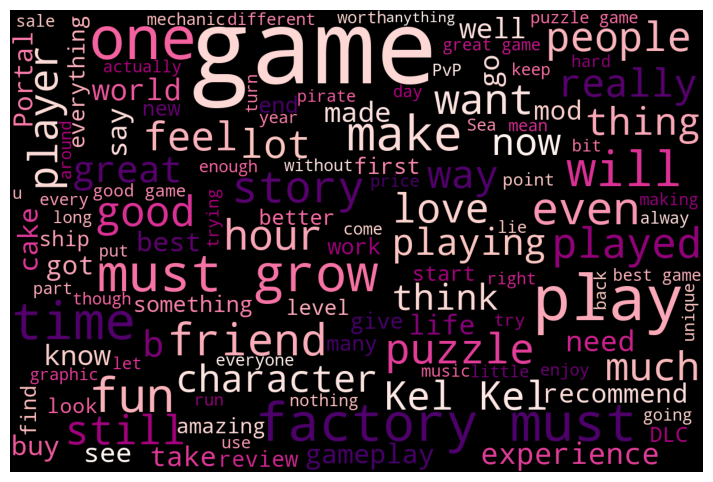

In [79]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

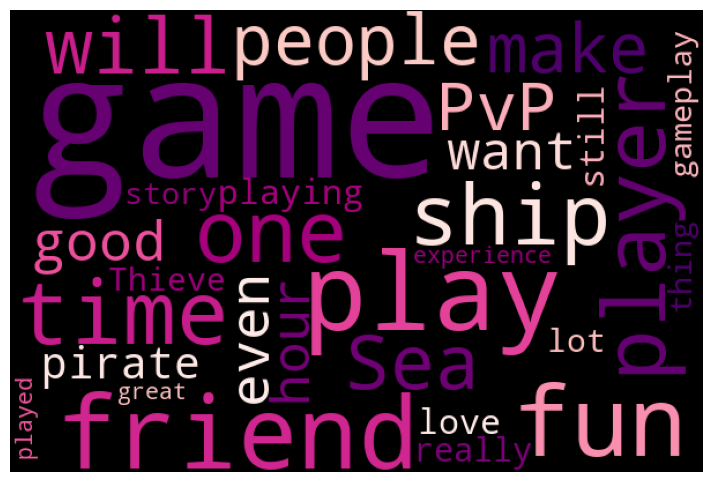

In [80]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

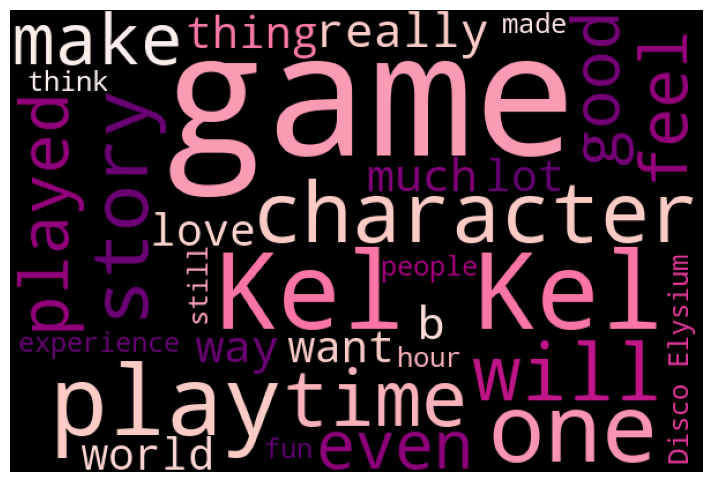

In [81]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

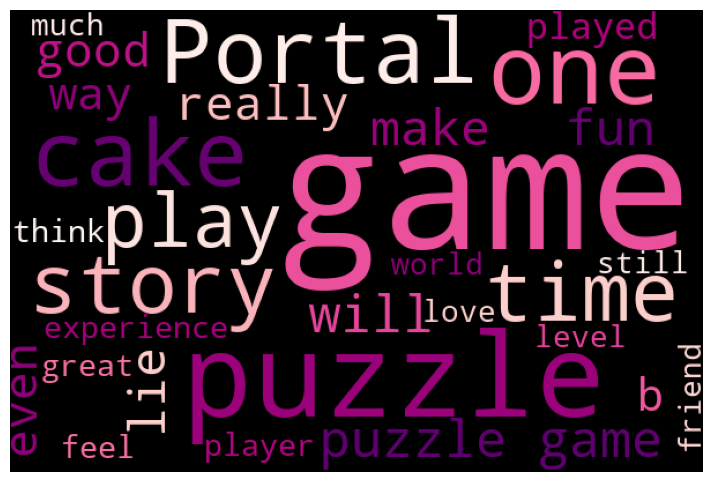

In [82]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

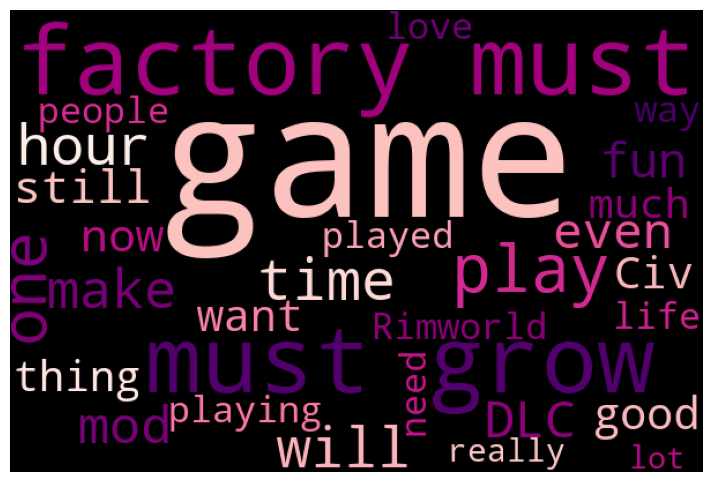

In [83]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [84]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [85]:
df["review"].sample(10)

1335     this is my favorite game of all time. before i...
21222    beautifully written game, huge bang for your b...
13101                            best game made in history
20433    certainly my go-to sim.  lots of playability w...
13127                                      it's a fun game
10591    doesn't run stable on multiplayer. crashes, gl...
3023     7h in and i'm seeing a bit of a problem. was c...
11172    doesn't even start after last update, nothing ...
31651                     best game ever! plus first game.
1361     game gave me depression but the ost slaps.plea...
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [86]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [87]:
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [88]:
df["review"].sample(5)

2907     they made the fov  and called it  which is as ...
22132                  its still best co op zombie shooter
3035     you spend more time thinking about life than p...
12464    furries officially added to rimworld the end t...
26007    just finished portal  and am pretty much speec...
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [89]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [90]:
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [91]:
df["tokenized"].sample(15)

28006    [got, to, get, to, get, downfind, a, rhythm, t...
30952    [this, game, is, fantastic, with, and, insane,...
30594    [art, gameplay, art, at, first, the, illustrat...
13672                       [harvest, organs, free, monye]
9552                   [its, dark, and, it, has, dungeons]
7051     [it, is, such, a, great, game, i, loved, playi...
6152     [if, youre, looking, for, a, game, to, play, w...
20011    [not, for, everybody, but, if, it, is, for, yo...
29167    [youll, look, like, a, fing, pansy, without, t...
19641    [my, wife, and, kids, left, me, but, the, fact...
26197    [incredible, story, iconic, characters, phenom...
7961     [one, of, the, best, indie, games, i, played, ...
86       [i, am, currently, contemplating, my, life, de...
20198    [if, you, have, a, kink, for, perfect, ratios,...
30091    [great, game, would, be, a, nazi, racist, femi...
Name: tokenized, dtype: object

### Stopwords

In [92]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [94]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [95]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [96]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [97]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_5112\2159658958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


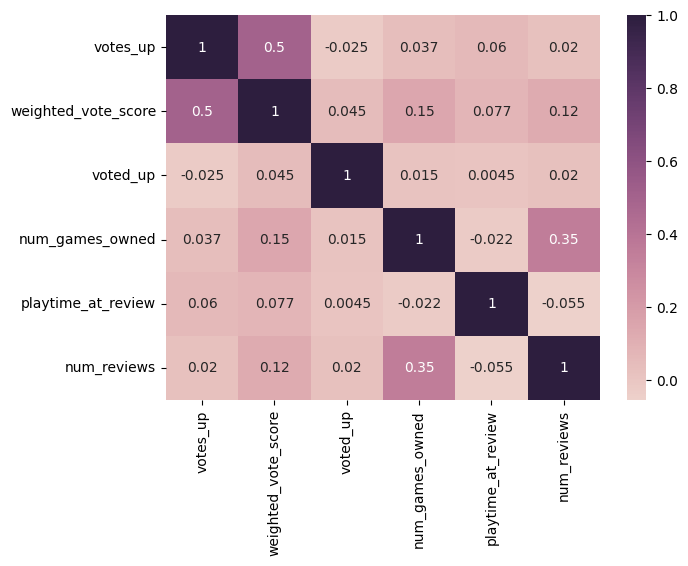

In [98]:
corr = df.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

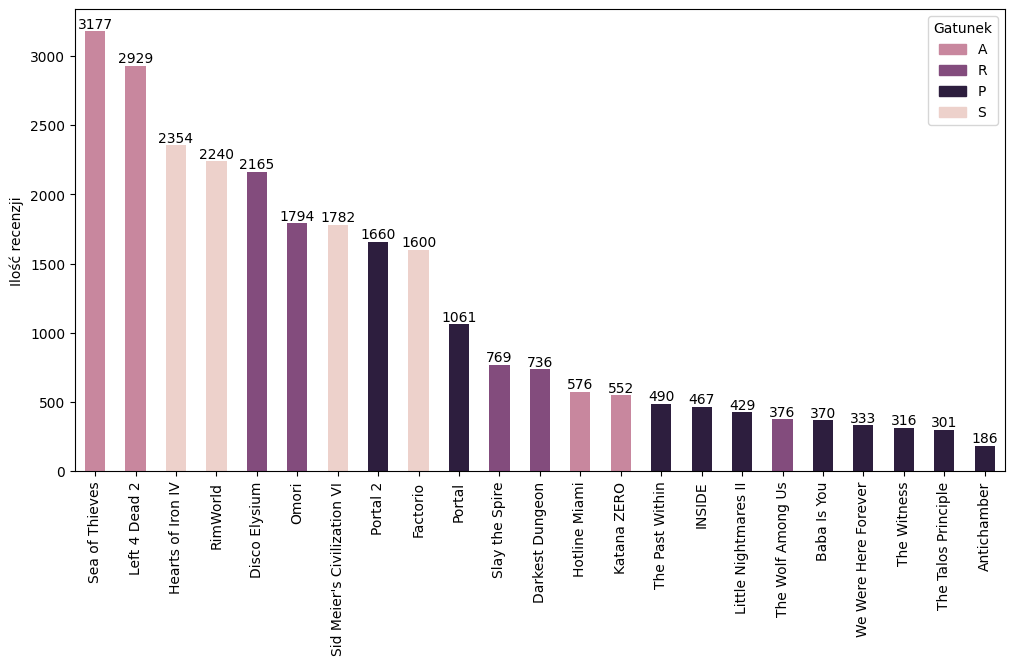

In [99]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

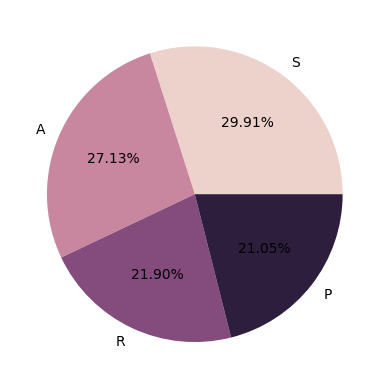

In [100]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

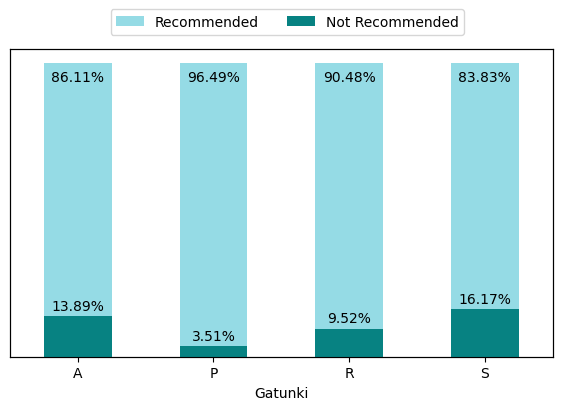

In [101]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [102]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [103]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-04-23 19:31:22 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-23 19:31:22 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-04-23 19:31:23 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-04-23 19:31:23 INFO: Using device: cuda
2024-04-23 19:31:23 INFO: Loading: tokenize
2024-04-23 19:31:23 INFO: Loading: mwt
2024-04-23 19:31:23 INFO: Loading: pos
2024-04-23 19:31:24 INFO: Loading: lemma
2024-04-23 19:31:24 INFO: Loading: constituency
2024-04-23 19:31:24 INFO: Loading: depparse
2024-04-23 19:31:25 INFO: Loading: sentiment
2024-04-23 19:31:25 INFO: Loading: ne

In [104]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:20], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']
['but', 'want', 'cc']
['cant', 'want', 'aux']
['really', 'want', 'advmod']
['want', 'crewing', 'conj']
['like', 'graphics', 'discourse']
['game', 'fun', 'compound']
['fun', 'graphics', 'amod']
['graphics', 'want', 'obj']
['basic', 'want', 'xcomp']
['but', 'have', 'cc']


In [105]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [106]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [107]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [108]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]

## Word embedding

## Correct misspeld words

In [109]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

## Similarity

### Word counts

In [110]:
unique_words = list(set(words))

In [111]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

## K-means

In [170]:
popular_words = word_counts[word_counts['count']>=15]["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

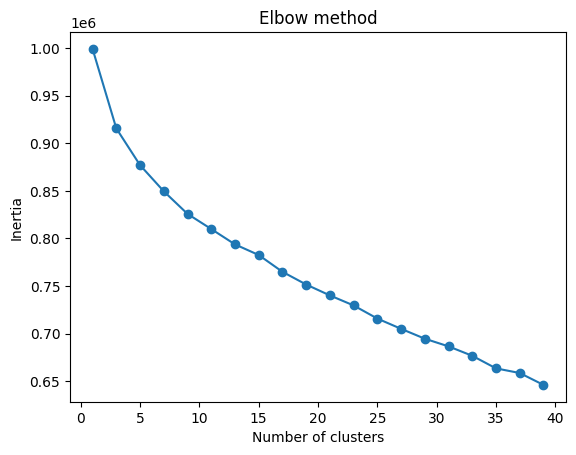

In [113]:
inertias = []
for i in range(1,40, 2):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init = 100, random_state=3)
    kmeans.fit(word_vectors)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1,40, 2), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [114]:
kmeans = joblib.load('kmeans_model.pkl')

In [115]:
clustered_words = joblib.load('kmeans_clustered_data.pkl')

In [120]:
clustered_words

,word,cluster
0,game,23
1,puzzle,2
2,experience,36
3,gameplay,23
4,play,25
...,...,...
392,patch,10
393,behavior,36
394,fortress,16
395,formula,36


In [160]:
cluster_1_words = clustered_words.loc[clustered_words['cluster'] == 38, 'word']
print(cluster_1_words)

Series([], Name: word, dtype: object)


In [131]:
graphics = [3, 20]
people = [5]
price = [6]
feelings = [7, 32, 37]
combat = [8, 26, 34]
bug = [9]
all = [11, 29, 35 ]
backstory = [15, 33]
universe = [16, 19]
game = [23, 25, 31]

In [163]:
# Inicjalizacja pustych list dla każdej kategorii
graphics = []
people = []
price = []
feelings = []
combat = []
bug = []
all_clusters = []
backstory = []
universe = []
game = []

# Przypisanie numerów klastrów do odpowiednich list
for word, cluster in zip(clustered_words['word'], clustered_words['cluster']):
    if cluster in [3, 20]:
        graphics.append(word)
        all_clusters.append(word)
    elif cluster in [5]:
        people.append(word)
        all_clusters.append(word)
    elif cluster in [6]:
        price.append(word)
        all_clusters.append(word)
    elif cluster in [7, 32, 37]:
        feelings.append(word)
        all_clusters.append(word)
    elif cluster in [8, 26, 34]:
        combat.append(word)
        all_clusters.append(word)
    elif cluster in [9]:
        bug.append(word)
        all_clusters.append(word)
    elif cluster in [11, 29, 35]:
        all_clusters.append(word)
    elif cluster in [15, 33]:
        backstory.append(word)
        all_clusters.append(word)
    elif cluster in [16, 19]:
        universe.append(word)
        all_clusters.append(word)
    elif cluster in [23, 25, 31]:
        game.append(word)
        all_clusters.append(word)

# Wydrukowanie list dla każdej kategorii
print("Graphics:", graphics)
print("People:", people)
print("Price:", price)
print("Feelings:", feelings)
print("Combat:", combat)
print("Bug:", bug)
print("All clusters:", all_clusters)
print("Backstory:", backstory)
print("Universe:", universe)
print("Game:", game)

Graphics: ['box', 'button', 'page', 'ui']
People: ['guy', 'kid', 'boy', 'woman', 'girl']
Price: ['price', 'rate', 'cost']
Feelings: ['love', 'care', 'humor', 'vibe', 'joy', 'risk', 'gem', 'quirk', 'charm']
Combat: ['enemy', 'war', 'weapon', 'raid', 'gun', 'fire', 'raider', 'bomb']
Bug: ['bug', 'glitch']
All clusters: ['game', 'gameplay', 'play', 'player', 'price', 'love', 'character', 'world', 'lot', 'life', 'bit', 'colony', 'room', 'bug', 'civ', 'enemy', 'pvp', 'guy', 'need', 'colonist', 'war', 'cant', 'hero', 'fan', 'rpg', 'genre', 'kid', 'city', 'horror', 'weapon', 'plot', 'playing', 'empire', 'boy', 'name', 'gamer', 'episode', 'book', 'wall', 'god', 'country', 'raid', 'care', 'gaming', 'planet', 'humor', 'video', 'landscape', 'cutscene', 'havent', 'gun', 'classic', 'fps', 'lore', 'woman', 'can', 'vibe', 'joy', 'box', 'universe', 'fire', 'chapter', 'family', 'era', 'girl', 'legend', 'pc', 'novel', 'risk', 'gem', 'button', 'raider', 'glitch', 'body', 'quirk', 'protagonist', 'page', '

In [196]:
for i in tokens:
    for j in tokens:
        if str(j) in backstory:
            if i.similarity(j) > 0.5:
                print(round(i.similarity(j), 2), i,j)


1.0 character character
0.53 character genre
0.55 character plot
0.53 character novel
0.82 character protagonist
0.65 character narrator
0.64 character backstory
0.53 feature character
0.57 feature classic
0.53 element character
0.59 concept character
0.51 concept backstory
1.0 hero hero
0.58 hero legend
0.6 hero protagonist
1.0 fan fan
0.53 genre character
1.0 genre genre
0.61 genre horror
0.51 genre cutscene
0.58 genre classic
0.61 horror genre
1.0 horror horror
0.55 voice narrator
0.55 plot character
1.0 plot plot
0.53 plot protagonist
0.6 plot backstory
0.55 emotion character
0.53 history lore
0.56 history backstory
1.0 name name
1.0 episode episode
1.0 book book
0.58 book chapter
0.69 book novel
0.57 book backstory
0.7 narrative character
0.56 narrative genre
0.53 narrative plot
0.59 narrative protagonist
0.63 narrative narrator
0.71 narrative backstory
1.0 god god
0.59 zombie horror
0.52 writing book
0.51 humor horror
0.51 cutscene genre
1.0 cutscene cutscene
0.7 personality char

C:\Users\marty\AppData\Local\Temp\ipykernel_5112\706340464.py:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if i.similarity(j) > 0.5:


In [ ]:
uncategorized_words = []
for i in popular_words:
    if i not in process_clusters(clustered_words, cluster_mapping):
        uncategorized_words.append(i)

In [ ]:
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in uncategorized_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

## Categories